# New Jersey Housing Price Prediction - Tree Models

CART, Random Forest, Gradient Boosting, XGBoost


## 1. Setup and Load Data


In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [210]:
df = pd.read_csv('housing_nj.csv', index_col=0)
print(f"Original dataset: {df.shape}")
df.head()


Original dataset: (5711, 20)


,url,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
190246,https://cnj.craigslist.org/apa/d/princeton-wal...,central NJ,3450,house,1300,3,1.5,0,0,0,0,0,0,w/d in unit,off-street parking,https://images.craigslist.org/00G0G_hGPrpUBJTm...,3 Bedroom house close to everything.,40.3521,-74.6625,nj
190276,https://newjersey.craigslist.org/apa/d/jersey-...,north jersey,2205,apartment,660,1,1.0,1,1,1,1,0,0,w/d in unit,attached garage,https://images.craigslist.org/00z0z_5R0Ry768Di...,"Contact info: DANIEL MENDEZ | MENDEZ GRP, Conl...",40.7372,-74.0676,nj
190313,https://newjersey.craigslist.org/apa/d/jersey-...,north jersey,2205,apartment,723,1,1.0,1,1,1,1,0,0,NaN,attached garage,https://images.craigslist.org/01414_kK1SLNbzbU...,"Contact info: DANIEL MENDEZ | MENDEZ GRP, Conl...",40.7372,-74.0676,nj
190331,https://jerseyshore.craigslist.org/apa/d/asbur...,jersey shore,1425,loft,1300,2,1.0,0,0,0,0,0,0,no laundry on site,off-street parking,https://images.craigslist.org/00C0C_fy5OrsKWWv...,"2 full Bedrooms, loft apartment on 3rd floor ...",40.2507,-74.0486,nj
190340,https://newjersey.craigslist.org/apa/d/jersey-...,north jersey,1805,apartment,510,0,1.0,1,1,1,1,0,0,w/d in unit,attached garage,https://images.craigslist.org/00z0z_5R0Ry768Di...,"Contact info: DANIEL MENDEZ | MENDEZ GRP, Conl...",40.7372,-74.0676,nj


## 2. Data Cleaning


In [211]:
df_clean = df.copy()

print("Cleaning data...")
print(f"Before: {len(df_clean)} rows")

df_clean = df_clean[df_clean['price'] > 0]
print(f"After removing price=0: {len(df_clean)} rows")

df_clean = df_clean[df_clean['sqfeet'] > 0]
print(f"After removing sqfeet=0: {len(df_clean)} rows")

df_clean = df_clean[(df_clean['lat'] >= 38.9) & (df_clean['lat'] <= 41.5)]
df_clean = df_clean[(df_clean['long'] >= -75.6) & (df_clean['long'] <= -73.9)]
print(f"After filtering NJ coordinates: {len(df_clean)} rows")

Q1 = df_clean['price'].quantile(0.01)
Q3 = df_clean['price'].quantile(0.99)
df_clean = df_clean[(df_clean['price'] >= Q1) & (df_clean['price'] <= Q3)]
print(f"After removing extreme outliers: {len(df_clean)} rows")

print(f"\nFinal dataset: {df_clean.shape}")


Cleaning data...
Before: 5711 rows
After removing price=0: 5709 rows
After removing sqfeet=0: 5706 rows
After filtering NJ coordinates: 5569 rows
After removing extreme outliers: 5459 rows

Final dataset: (5459, 20)


## 3. Feature Engineering


In [212]:
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['sqfeet']
df_clean['total_rooms'] = df_clean['beds'] + df_clean['baths']

amenities = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 
             'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']
df_clean['amenity_count'] = df_clean[amenities].sum(axis=1)

df_clean['has_laundry'] = df_clean['laundry_options'].notna().astype(int)
df_clean['has_parking'] = df_clean['parking_options'].notna().astype(int)

print("Engineered features created:")
print(df_clean[['price_per_sqft', 'total_rooms', 'amenity_count', 
                'has_laundry', 'has_parking']].describe())


Engineered features created:
       price_per_sqft  total_rooms  amenity_count  has_laundry  has_parking
count     5459.000000  5459.000000    5459.000000  5459.000000  5459.000000
mean         3.199572     3.144715       2.254259     0.795201     0.685474
std         46.154347     1.225207       1.113320     0.403592     0.464370
min          0.076253     1.000000       0.000000     0.000000     0.000000
25%          1.423659     2.000000       1.000000     1.000000     0.000000
50%          1.690821     3.000000       3.000000     1.000000     1.000000
75%          2.097902     4.000000       3.000000     1.000000     1.000000
max       2284.000000     9.000000       6.000000     1.000000     1.000000


## 4. Preprocessing


In [213]:
feature_cols = ['sqfeet', 'beds', 'baths', 'lat', 'long',
                'cats_allowed', 'dogs_allowed', 'smoking_allowed',
                'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
                'total_rooms', 'amenity_count', 'has_laundry', 'has_parking',
                'region', 'type']

df_model = df_clean[feature_cols + ['price']].copy()

df_model = pd.get_dummies(df_model, columns=['region', 'type'], drop_first=True)

print(f"Features after encoding: {df_model.shape[1] - 1}")
print(f"Total samples: {len(df_model)}")


Features after encoding: 26
Total samples: 5459


In [214]:
X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (4367, 26)
Test set: (1092, 26)


## 5. Model 1: CART (Decision Tree)


In [215]:
print("Training CART...")

param_grid_cart = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cart = DecisionTreeRegressor(random_state=42)
grid_cart = GridSearchCV(cart, param_grid_cart, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cart.fit(X_train_scaled, y_train)

best_cart = grid_cart.best_estimator_
y_pred_cart = best_cart.predict(X_test_scaled)

rmse_cart = np.sqrt(mean_squared_error(y_test, y_pred_cart))
mae_cart = mean_absolute_error(y_test, y_pred_cart)
r2_cart = r2_score(y_test, y_pred_cart)

print(f"Best params: {grid_cart.best_params_}")
print(f"RMSE: ${rmse_cart:.2f}")
print(f"MAE: ${mae_cart:.2f}")
print(f"R²: {r2_cart:.4f}")


Training CART...
Best params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
RMSE: $281.84
MAE: $134.84
R²: 0.7558


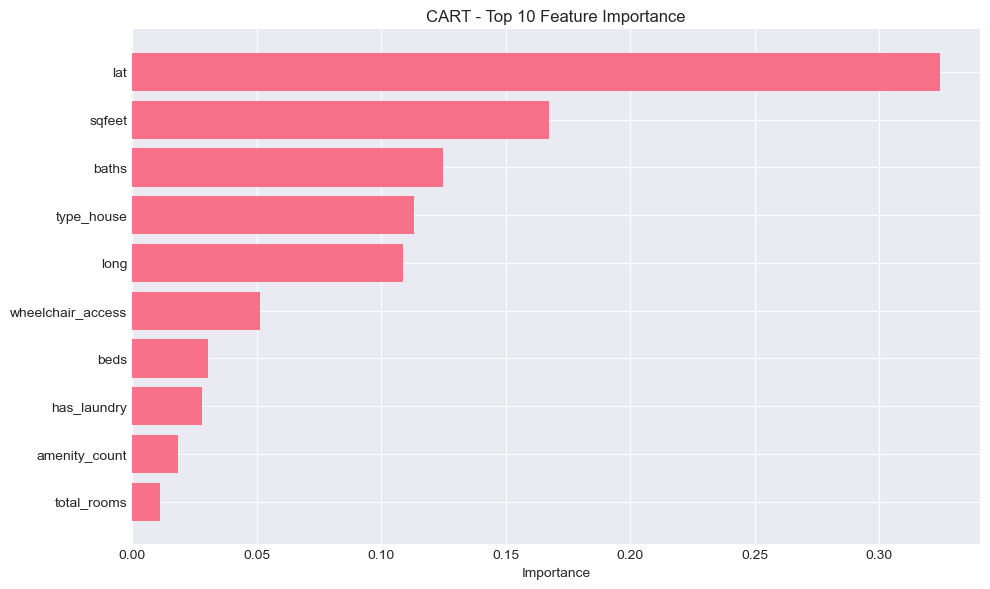

In [216]:
feature_importance_cart = pd.DataFrame({
    'feature': X.columns,
    'importance': best_cart.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_cart['feature'], feature_importance_cart['importance'])
plt.xlabel('Importance')
plt.title('CART - Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [217]:
best_var_cart = feature_importance_cart.iloc[0]
print(f"\nBEST VARIABLE: {best_var_cart['feature']} (importance: {best_var_cart['importance']:.4f})")



BEST VARIABLE: lat (importance: 0.3243)


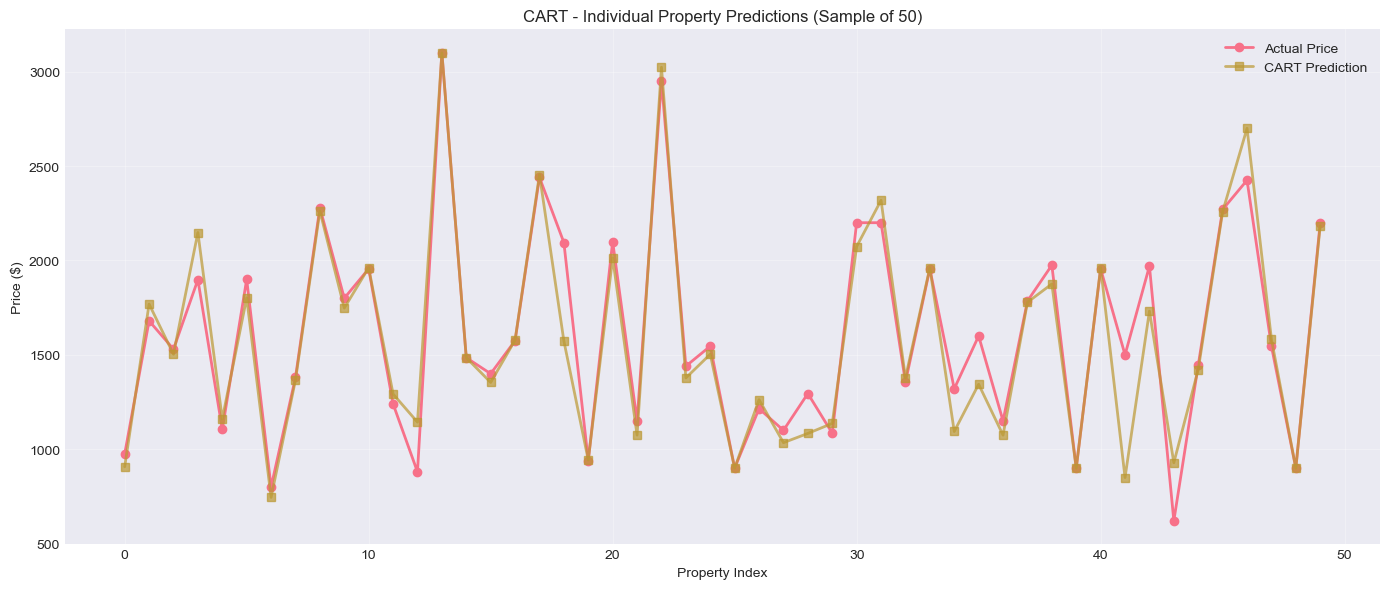

In [218]:
sample_size = 50
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

plt.figure(figsize=(14, 6))
x_pos = np.arange(sample_size)
plt.plot(x_pos, y_test.iloc[sample_indices].values, 'o-', label='Actual Price', linewidth=2, markersize=6)
plt.plot(x_pos, y_pred_cart[sample_indices], 's-', label='CART Prediction', linewidth=2, markersize=6, alpha=0.7)
plt.xlabel('Property Index')
plt.ylabel('Price ($)')
plt.title(f'CART - Individual Property Predictions (Sample of {sample_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Model 2: Random Forest


In [219]:
print("Training Random Forest...")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best params: {grid_rf.best_params_}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"MAE: ${mae_rf:.2f}")
print(f"R²: {r2_rf:.4f}")


Training Random Forest...
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
RMSE: $195.09
MAE: $96.34
R²: 0.8830


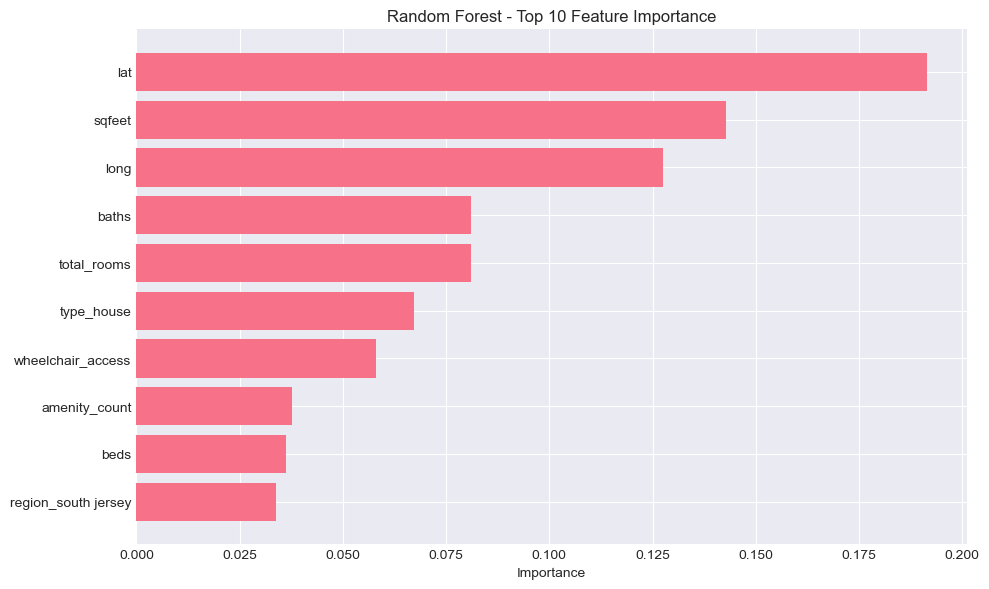

In [220]:
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['feature'], feature_importance_rf['importance'])
plt.xlabel('Importance')
plt.title('Random Forest - Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [221]:
best_var_rf = feature_importance_rf.iloc[0]
print(f"\nBEST VARIABLE: {best_var_rf['feature']} (importance: {best_var_rf['importance']:.4f})")



BEST VARIABLE: lat (importance: 0.1916)


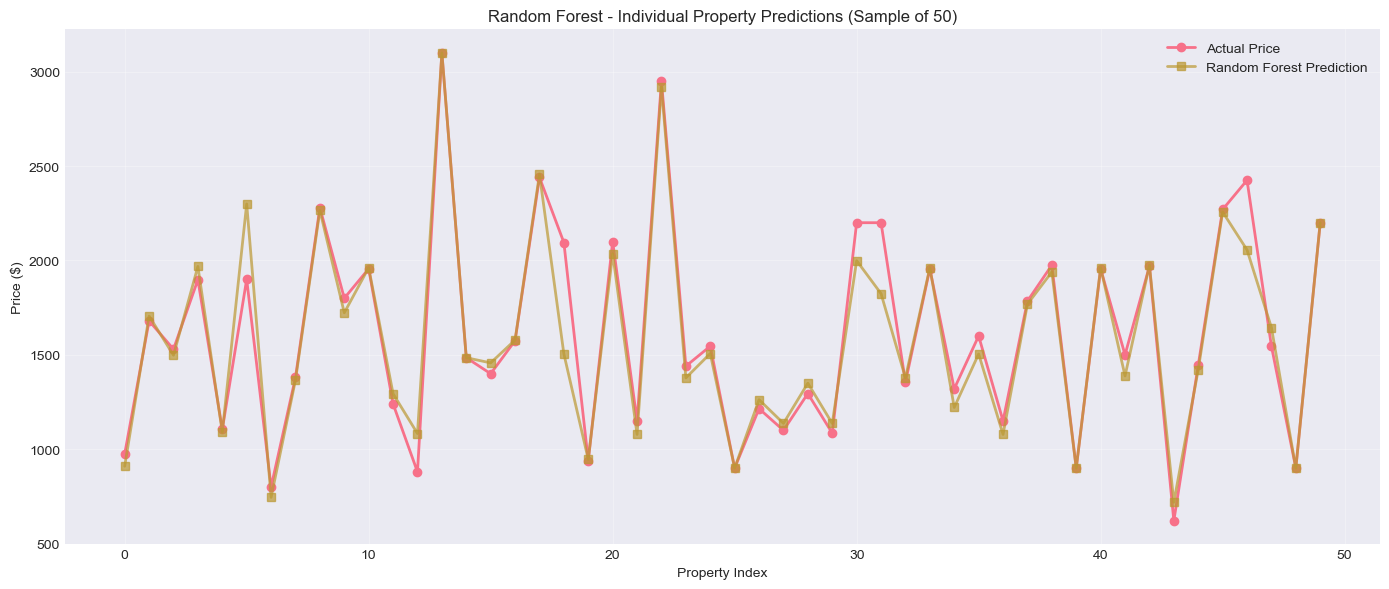

In [222]:
plt.figure(figsize=(14, 6))
x_pos = np.arange(sample_size)
plt.plot(x_pos, y_test.iloc[sample_indices].values, 'o-', label='Actual Price', linewidth=2, markersize=6)
plt.plot(x_pos, y_pred_rf[sample_indices], 's-', label='Random Forest Prediction', linewidth=2, markersize=6, alpha=0.7)
plt.xlabel('Property Index')
plt.ylabel('Price ($)')
plt.title(f'Random Forest - Individual Property Predictions (Sample of {sample_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Model 3: Gradient Boosting


In [223]:
print("Training Gradient Boosting...")

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingRegressor(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train)

best_gb = grid_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Best params: {grid_gb.best_params_}")
print(f"RMSE: ${rmse_gb:.2f}")
print(f"MAE: ${mae_gb:.2f}")
print(f"R²: {r2_gb:.4f}")


Training Gradient Boosting...
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
RMSE: $203.60
MAE: $110.94
R²: 0.8725


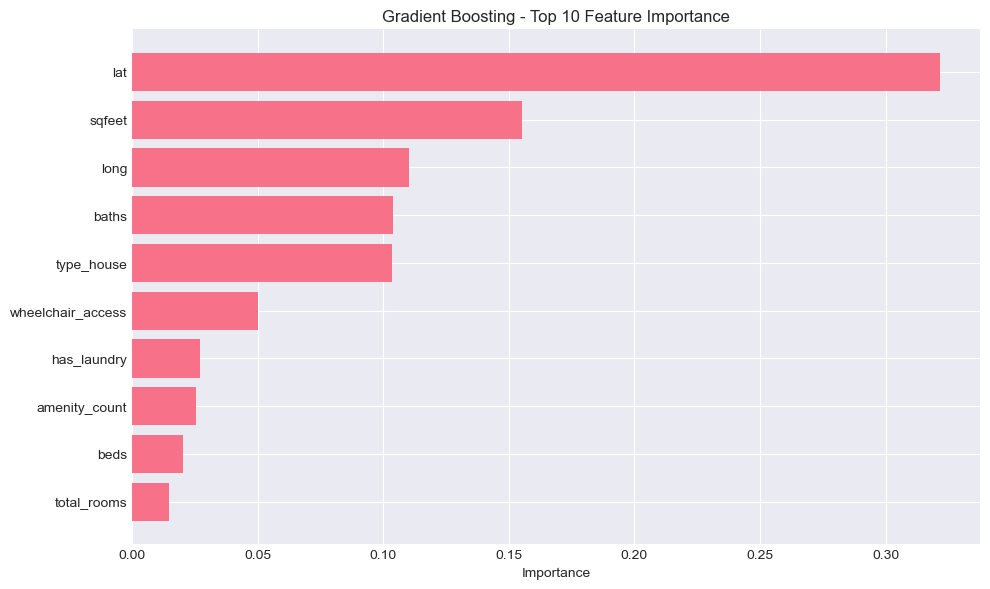

In [224]:
feature_importance_gb = pd.DataFrame({
    'feature': X.columns,
    'importance': best_gb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_gb['feature'], feature_importance_gb['importance'])
plt.xlabel('Importance')
plt.title('Gradient Boosting - Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [225]:
best_var_gb = feature_importance_gb.iloc[0]
print(f"\nBEST VARIABLE: {best_var_gb['feature']} (importance: {best_var_gb['importance']:.4f})")



BEST VARIABLE: lat (importance: 0.3215)


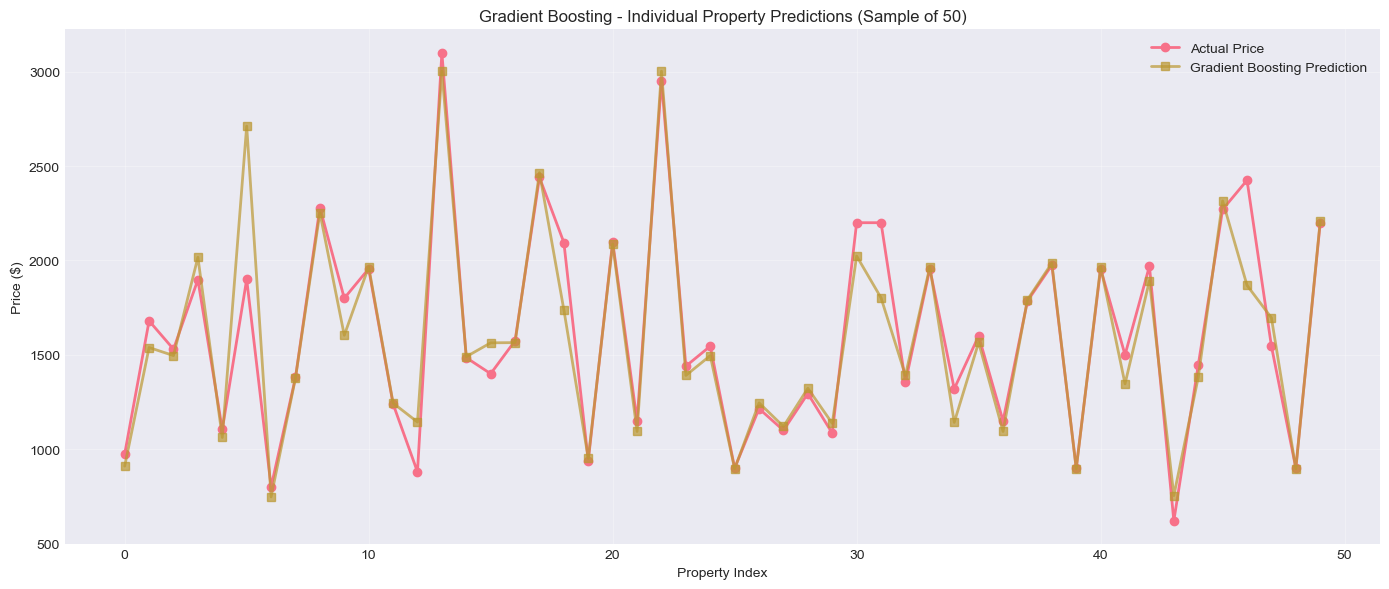

In [226]:
plt.figure(figsize=(14, 6))
x_pos = np.arange(sample_size)
plt.plot(x_pos, y_test.iloc[sample_indices].values, 'o-', label='Actual Price', linewidth=2, markersize=6)
plt.plot(x_pos, y_pred_gb[sample_indices], 's-', label='Gradient Boosting Prediction', linewidth=2, markersize=6, alpha=0.7)
plt.xlabel('Property Index')
plt.ylabel('Price ($)')
plt.title(f'Gradient Boosting - Individual Property Predictions (Sample of {sample_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Model 4: XGBoost


In [227]:
print("Training XGBoost...")

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train_scaled, y_train)

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Best params: {grid_xgb.best_params_}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"MAE: ${mae_xgb:.2f}")
print(f"R²: {r2_xgb:.4f}")


Training XGBoost...
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE: $214.46
MAE: $118.22
R²: 0.8586


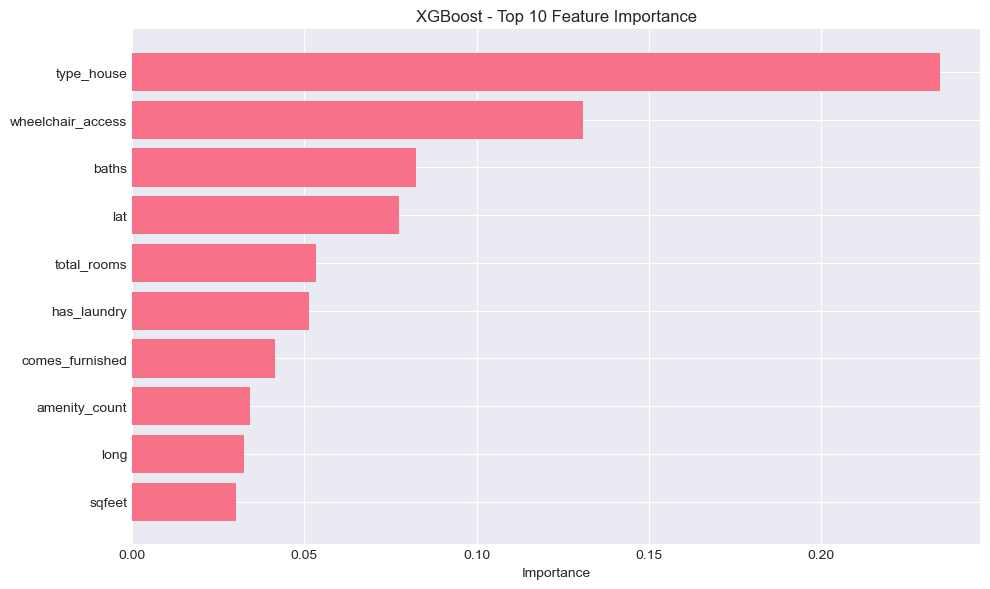

In [228]:
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'])
plt.xlabel('Importance')
plt.title('XGBoost - Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [229]:
best_var_xgb = feature_importance_xgb.iloc[0]
print(f"\nBEST VARIABLE: {best_var_xgb['feature']} (importance: {best_var_xgb['importance']:.4f})")



BEST VARIABLE: type_house (importance: 0.2343)


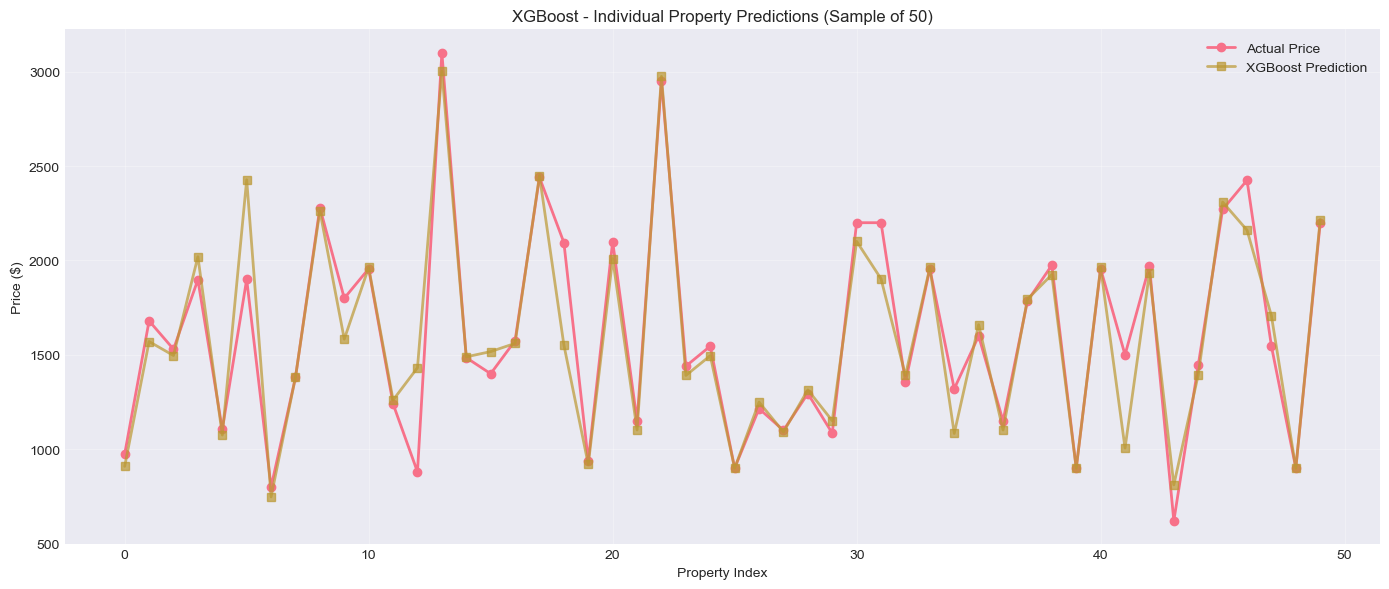

In [230]:
plt.figure(figsize=(14, 6))
x_pos = np.arange(sample_size)
plt.plot(x_pos, y_test.iloc[sample_indices].values, 'o-', label='Actual Price', linewidth=2, markersize=6)
plt.plot(x_pos, y_pred_xgb[sample_indices], 's-', label='XGBoost Prediction', linewidth=2, markersize=6, alpha=0.7)
plt.xlabel('Property Index')
plt.ylabel('Price ($)')
plt.title(f'XGBoost - Individual Property Predictions (Sample of {sample_size})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Model Comparison


In [231]:
results = pd.DataFrame({
    'Model': ['CART', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'RMSE': [rmse_cart, rmse_rf, rmse_gb, rmse_xgb],
    'MAE': [mae_cart, mae_rf, mae_gb, mae_xgb],
    'R²': [r2_cart, r2_rf, r2_gb, r2_xgb]
})

results = results.sort_values('RMSE')
print("\nModel Comparison:")
print(results.to_string(index=False))

best_model_name = results.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")



Model Comparison:
            Model       RMSE        MAE       R²
    Random Forest 195.094338  96.336037 0.882969
Gradient Boosting 203.599838 110.941796 0.872543
          XGBoost 214.456991 118.224709 0.858587
             CART 281.843174 134.836922 0.755755

Best Model: Random Forest


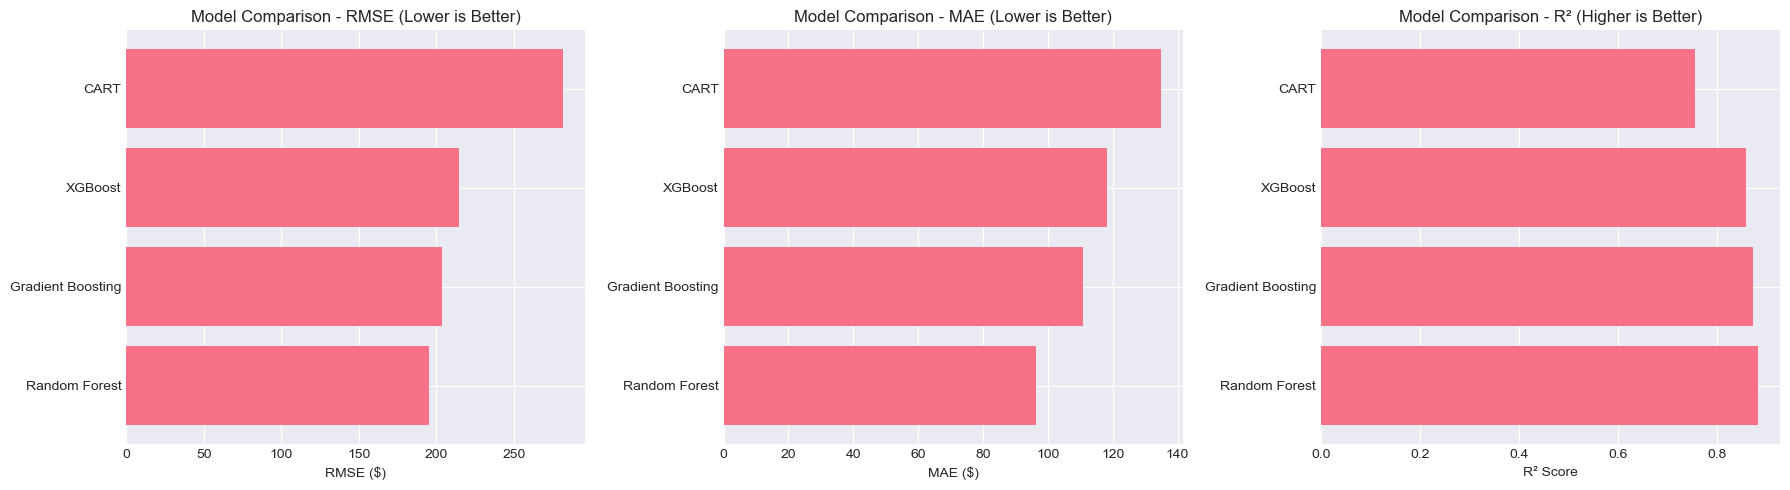

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

results_sorted = results.sort_values('RMSE', ascending=False)
axes[0].barh(results_sorted['Model'], results_sorted['RMSE'])
axes[0].set_xlabel('RMSE ($)')
axes[0].set_title('Model Comparison - RMSE (Lower is Better)')
axes[0].invert_yaxis()

results_sorted = results.sort_values('MAE', ascending=False)
axes[1].barh(results_sorted['Model'], results_sorted['MAE'])
axes[1].set_xlabel('MAE ($)')
axes[1].set_title('Model Comparison - MAE (Lower is Better)')
axes[1].invert_yaxis()

results_sorted = results.sort_values('R²')
axes[2].barh(results_sorted['Model'], results_sorted['R²'])
axes[2].set_xlabel('R² Score')
axes[2].set_title('Model Comparison - R² (Higher is Better)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


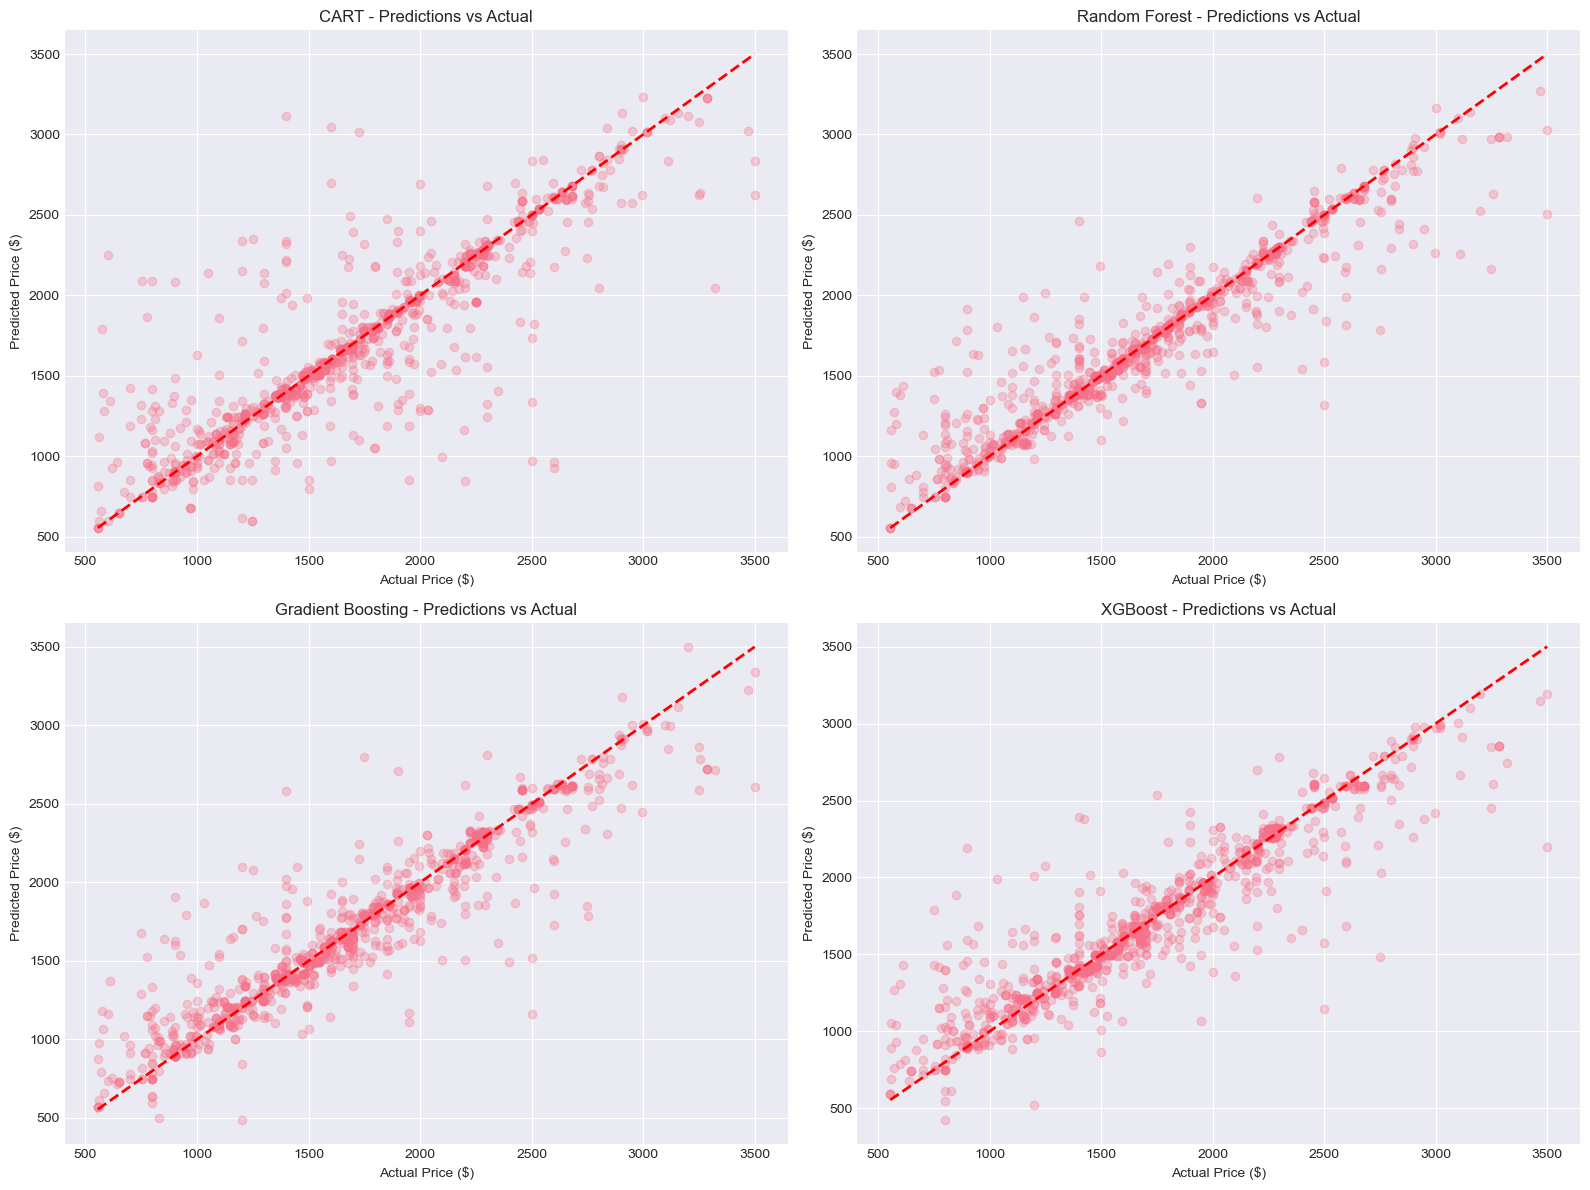

In [233]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_pred = [
    ('CART', y_pred_cart),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb),
    ('XGBoost', y_pred_xgb)
]

for idx, (name, y_pred) in enumerate(models_pred):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(y_test, y_pred, alpha=0.3)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Price ($)')
    ax.set_ylabel('Predicted Price ($)')
    ax.set_title(f'{name} - Predictions vs Actual')

plt.tight_layout()
plt.show()


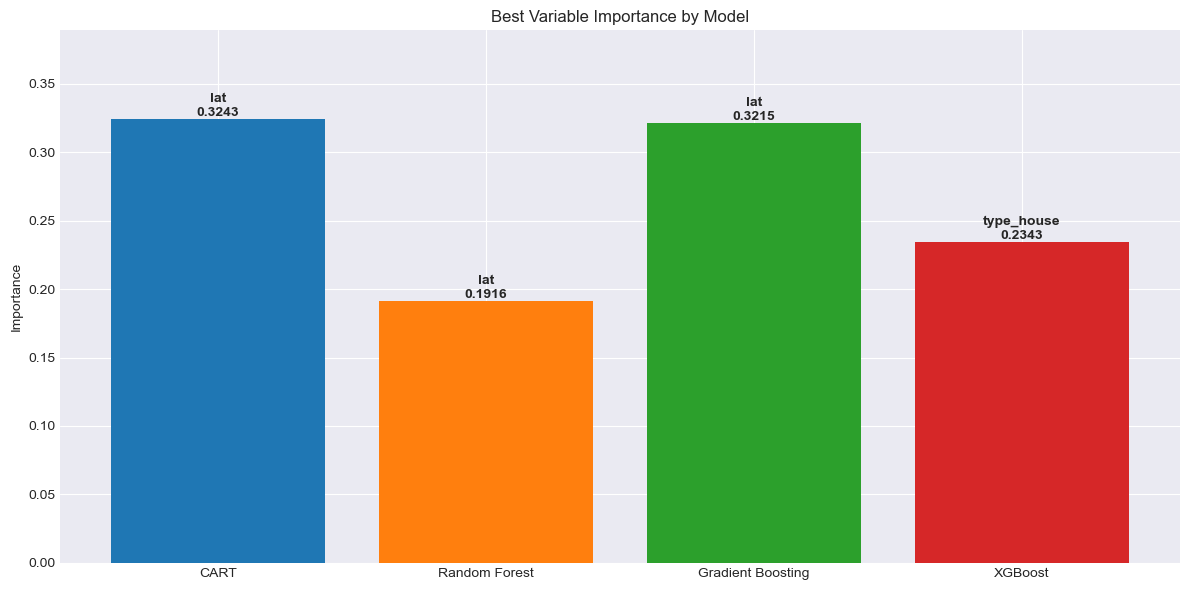

In [234]:
fig, ax = plt.subplots(figsize=(12, 6))

models = ['CART', 'Random Forest', 'Gradient Boosting', 'XGBoost']
best_vars = [best_features[m]['feature'] for m in models]
importance_vals = [best_features[m]['importance'] for m in models]

bars = ax.bar(models, importance_vals, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_ylabel('Importance')
ax.set_title('Best Variable Importance by Model')
ax.set_ylim(0, max(importance_vals) * 1.2)

for i, (bar, var) in enumerate(zip(bars, best_vars)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{var}\n{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [235]:
summary_table = pd.DataFrame({
    'Model': results['Model'],
    'RMSE': results['RMSE'].round(2),
    'R²': results['R²'].round(4),
    'Best Feature': [best_features[m]['feature'] for m in results['Model']],
    'Importance': [f"{best_features[m]['importance']:.4f}" for m in results['Model']]
})

print("\nMODEL COMPARISON:")
print(summary_table.to_string(index=False))



MODEL COMPARISON:
            Model   RMSE     R² Best Feature Importance
    Random Forest 195.09 0.8830          lat     0.1916
Gradient Boosting 203.60 0.8725          lat     0.3215
          XGBoost 214.46 0.8586   type_house     0.2343
             CART 281.84 0.7558          lat     0.3243


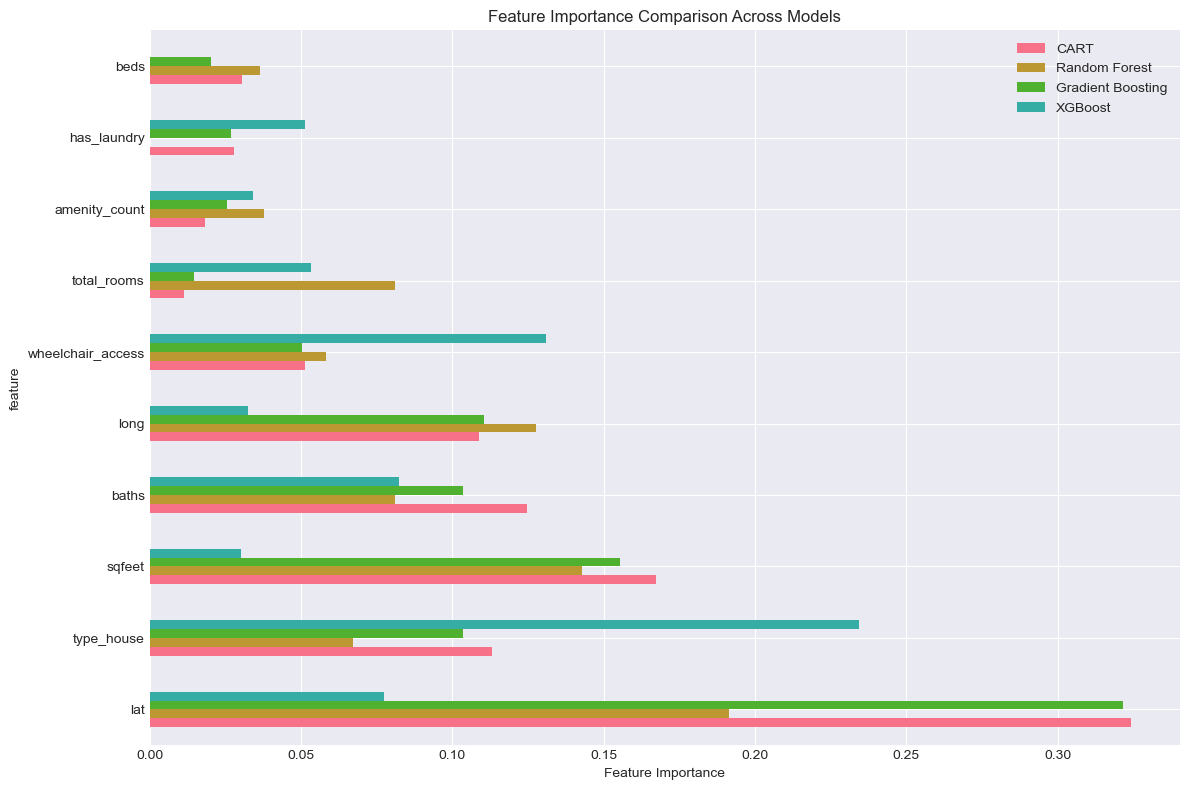

In [236]:
comparison_df = pd.DataFrame({
    'CART': feature_importance_cart.set_index('feature')['importance'],
    'Random Forest': feature_importance_rf.set_index('feature')['importance'],
    'Gradient Boosting': feature_importance_gb.set_index('feature')['importance'],
    'XGBoost': feature_importance_xgb.set_index('feature')['importance']
}).fillna(0)

comparison_df = comparison_df.loc[comparison_df.sum(axis=1).sort_values(ascending=False).head(10).index]

comparison_df.plot(kind='barh', figsize=(12, 8))
plt.xlabel('Feature Importance')
plt.title('Feature Importance Comparison Across Models')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Prompt que utilice


```
Tengo estas ciudades en donde:
   - Trenton (capital): lat ~40.22, Central NJ
   - NYC metro area: lat ~40.7-40.8, North NJ
   - South NJ: lat <40.0

Como puedo analizar la relacion en lat que es una de mis variables mas importantes 
para saber si el precio de la vivienda incrementa conforme se va acercando a la 
capital de los estados.

Obviamente estamos hablando de New Jersey.

Cloude 
```

In [239]:
df_price_lat = pd.DataFrame({
    'lat': [X_test.loc[idx, 'lat'] for idx in y_test.index],
    'price': y_test.values
})

correlation = df_price_lat.corr().iloc[0, 1]
print(f"Correlation lat vs price: {correlation:.4f}")

north_nj = df_price_lat[df_price_lat['lat'] > 40.6]['price'].mean()
central_nj = df_price_lat[(df_price_lat['lat'] >= 40.0) & (df_price_lat['lat'] <= 40.4)]['price'].mean()
south_nj = df_price_lat[df_price_lat['lat'] < 40.0]['price'].mean()

print(f"\nNorth NJ (near NYC): ${north_nj:.2f}")
print(f"Central NJ (Trenton): ${central_nj:.2f}")
print(f"South NJ: ${south_nj:.2f}")

print(f"\nConclusion: North NJ (${north_nj:.2f}) > Central NJ (${central_nj:.2f})")
print("NYC influence > State capital influence")


Correlation lat vs price: 0.4367

North NJ (near NYC): $1902.52
Central NJ (Trenton): $1856.43
South NJ: $1388.85

Conclusion: North NJ ($1902.52) > Central NJ ($1856.43)
NYC influence > State capital influence


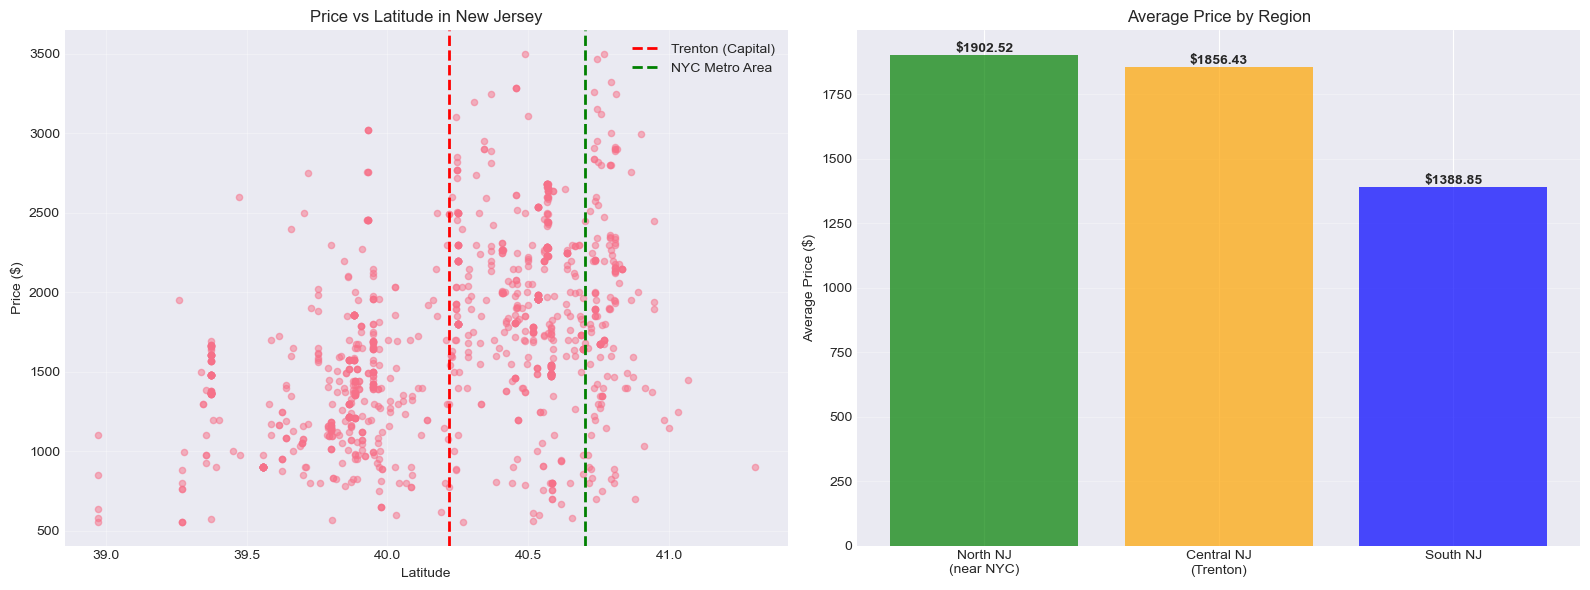

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(df_price_lat['lat'], df_price_lat['price'], alpha=0.5, s=20)
axes[0].axvline(x=40.22, color='red', linestyle='--', linewidth=2, label='Trenton (Capital)')
axes[0].axvline(x=40.7, color='green', linestyle='--', linewidth=2, label='NYC Metro Area')
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price vs Latitude in New Jersey')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

regions = ['North NJ\n(near NYC)', 'Central NJ\n(Trenton)', 'South NJ']
avg_prices = [north_nj, central_nj, south_nj]
colors = ['green', 'orange', 'blue']

bars = axes[1].bar(regions, avg_prices, color=colors, alpha=0.7)
axes[1].set_ylabel('Average Price ($)')
axes[1].set_title('Average Price by Region')
axes[1].grid(True, alpha=0.3, axis='y')

for bar, price in zip(bars, avg_prices):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'${price:.2f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## Conclusion Final

Podemos llegar a la conclusion de que el estado mas caro al parecer no es el mas cerca de la capital ni por el estilo. 

Este caso es diferente porque como esta cerca de una ciudad carisima que es New York, pues varios escogen la decision de rentar o comprar ahi porque es un poco mas barato pero no tan caro como NY, y por eso esas son las viviendas mas caras. 

Entonces si me hace sentido.

Por otro lado tenemos a nuestras variables que mas impactan e igual tiene sentido porque una de ellas es `lat`, entonces esto significa que la ubicacion geografica (latitud) es el factor mas determinante en el precio de las viviendas en New Jersey. Esto confirma que la proximidad a centros urbanos importantes como NYC es mas relevante que otros factores como el tipo de propiedad o sus caracteristicas fisicas.
